# Solving the Schrödinger equation by the split-step method

Fourier spectral and finite differences methods

* `expsolve.discretize.tensorgrid`

This notebook introduces you to the basic functionalities of `expsolve` with the example of the Schrödinger equation in 1D. Use Fourier spatial discretiation to illustrate this example and import `expsolve.fourier` as our spatial discretisation choice. Most notebooks that use a single choice of spatial discretisation import the spatial discretisation module as `ex`. Doing so allows us to quickly change spatial discretisation.

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import time 

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag
from torch.linalg import norm, matrix_exp

## The splitting approach for solving the Schrödinger equation

The splitting approach is to approximate the matrix exponential in 

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0) $$

as 

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i h\, \texttt{diag}(V) \right) $$

which is the 1st order approximation called the Trotter splitting (and h is the time step) or as

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) $$

which is the 2nd order approximation called the Strang splitting.

The overall numerical scheme (in the case of the Strang splitting) is:

$$ u_{n+1} = \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

Splitting is useful because we can compute the exponentials of $\texttt{diag}(V)$ and $\mathbf{D}_2$ much more cheaply separately than we can compute the exponential when they are combined in the full discrestised $\mathbf{H}$. For instance, the computation of the exponential of $\mathbf{H}$ using `matrix_exp` costs $\mathcal{O}\left(n^3\right)$ operations. On the other hand, expoential of $\texttt{diag}(V)$ can be computed in a pointwise way in $\mathcal{O}(n)$ operations, while exponential of $\mathbf{D}_2$ costs us $\mathcal{O}(n \log n)$ operations. The latter is because the Fourier differentiation matrices in `expsolve.fourier` can be diagonalised with the Fourier transform:

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} $$
where $s_k$ is the symbol of $\mathbf{D}_k$ (in particular, the $j$ th component of $s_k$ is $(s_k)_j = (-i j \pi)^k$). 

In `expsolve.fourier`, the function `diffop` computes the action of `\mathbf{D}_k` on vector `u` as 

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u = \texttt{ifft}\left(s_k\ \texttt{fft}(u) \right) $$

in $\mathcal{O}(n \log n)$ operations. This is why `diffop` is preexrred to `diffmatrix` followed by matrix-vector multiplication, which costs $\mathcal{O}(n^2)$ cost and storage.

We can easily see that 

$$ \left(\mathbf{D}_k\right)^n = \mathcal{F}^{-1} \texttt{diag}((s_k)^n) \mathcal{F} $$

With the help of Taylor expanion, we can also seee that exponential of $\mathbf{D}_k$ is

$$ \exp(c \mathbf{D}_k) = \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} $$

for any $c \in \mathbb{C}$, and it's action on a vector $u$ is computed in $\mathcal{O}(n \log n)$ operations as 

$$ \exp(c \mathbf{D}_k) u= \mathcal{F}^{-1} \texttt{diag}(\exp(c s_k)) \mathcal{F} u = \texttt{ifft}\left( \exp(c s_k) \texttt{fft}(u) \right) .$$

This functionality is implemented in the function `diffopexp`, whose syntax is:


```Python
    eDu = ex.diffopexp(j, k, c, u, xrange) 
```
which computes $\exp(c D_{j,k}) u$, where `u` is the vector of values on a periodic grid defined on the domain `xrange`, $D_{j,k}$ is the $k$ th differentiation operator in the $j$ th direction. 

* Since we are working in 1D here, $j=0$. 
* Since we need 2nd derivative, $k=2$. 

### Grid & Initial Condition

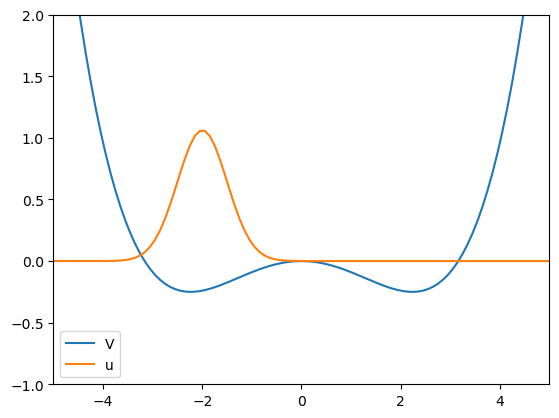

In [2]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    

V = x**4 - 10*x**2

ex.plot(plt, x, V/100)
ex.plot(plt, x, real(u))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

### A single step of Strang

We create lambda functions for computing $\exp(i h D_2) u$ and $\exp(-i h \texttt{diag}(V)) u$, and compose them to form a single step of Strang:

$$\exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

In [3]:
eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))

Let's run a single step of Strang for time step $h=0.1$ and compare it to the `matrix_exp` solution (which is exact to machine precision):

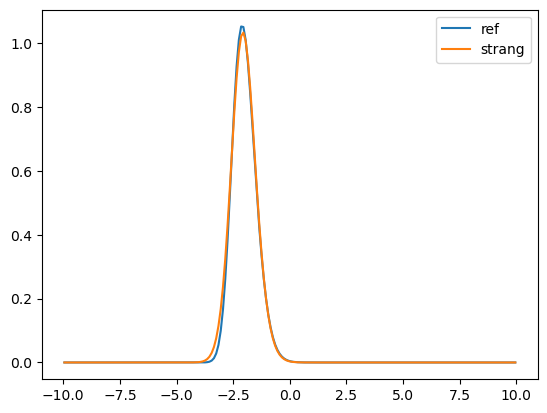

The L2 error in Strang splitting is tensor([0.0630], dtype=torch.float64)


In [4]:
D2 = ex.diffmatrix(2, n, xr)
H = -D2 + es.linalg.diag(V)
exact = lambda h, u: es.linalg.matmul(matrix_exp(-1j*h*H) , u)

h = 0.1

uref = exact(h, u)
ustrang = strang(h, u)

ex.plot(plt, x, abs(uref))
ex.plot(plt, x, abs(ustrang))
plt.legend(['ref','strang'])
plt.show()

print(f'The L2 error in Strang splitting is {ex.l2norm(uref-ustrang, xr)}')

### Full run of Strang up to time T = 1

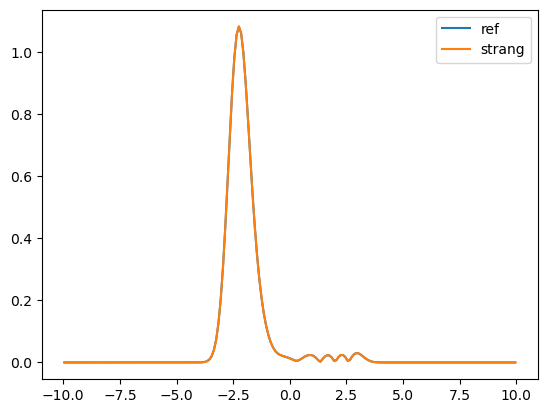

The L2 error in Strang splitting is tensor([1.6601e-05], dtype=torch.float64)


In [5]:
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

T = 1

urefT = exact(T, u)
ustrangT = runstrang(T,1000,u)
ex.plot(plt, x, abs(urefT))
ex.plot(plt, x, abs(ustrangT))
plt.legend(['ref','strang'])
plt.show()

print(f'The L2 error in Strang splitting is {ex.l2norm(urefT-ustrangT, xr)}')

When we run Strang splitting with a small enough time step, it becomes pretty accurate

### Analysing order of Strang

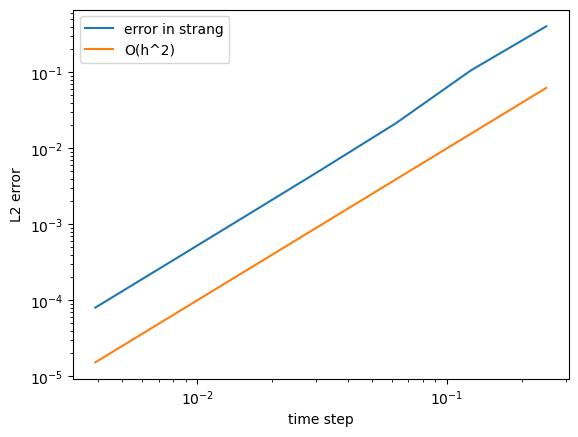

In [6]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist
err = [ex.l2norm(urefT-runstrang(T,N,u))[0] for N in Nlist]
plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in strang', 'O(h^2)'])
plt.show()

As we can see, the (global) error of Strang is $\mathcal{O}(h^2)$.

### A comparison of speed

When $n$ becomes large, `matrix_exp` is an extremely inefficient method since its cost scales as $\mathcal{O}\left(n^3\right)$. On the other hand, the cost of Strang scales as $\mathcal{O}\left(n \log n\right)$, which is significantly cheaper

In [7]:
n = 2000

L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    


V = x**4 - 10*x**2

T = 1

tic_exact = time.perf_counter()
D2 = ex.diffmatrix(2, n, xr)
H = -D2 + es.linalg.diag(V)
urefT = es.linalg.matmul(matrix_exp(-1j*T*H) , u)
toc_exact = time.perf_counter()
print(f'matrix_exp took {toc_exact-tic_exact:0.4f} seconds')

tic_strang = time.perf_counter()
eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

ustrangT = runstrang(T, 1000, u)
toc_strang = time.perf_counter()


print(f'Strang took {toc_strang-tic_strang:0.4f} seconds')

print(f'The L2 error in Strang splitting is {ex.l2norm(urefT-ustrangT, xr)}')

matrix_exp took 9.3492 seconds
Strang took 0.5671 seconds
The L2 error in Strang splitting is tensor([1.6571e-05], dtype=torch.float64)
